# This is a grok generated code's approach

In [14]:
import os
import faiss
import json
import torch
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from pathlib import Path

import matplotlib.pyplot as plt
from typing import Optional, List, Dict, Tuple, Self, Annotated

In [63]:
# ------------------------------------------------------------------------------------------------------------------------
# CLIP Model: main class
# ------------------------------------------------------------------------------------------------------------------------

class CLIPEmbeddings:
    """ Provide functions to generate image embeddings and process them """

    def __init__(
            self, 
            model_name: Optional[str] = "openai/clip-vit-base-patch32",
            image_dir: Optional[str] = "extracted_images",
            vector_store_name: Optional[str] = "image_embeddings_index.faiss",
            verbose: bool = True
            ) -> Self :
        
        """ Constructor

        Args:
            model_name (Optional[str], optional): Model name of CLIP model. Defaults to "openai/clip-vit-base-patch32".
            verbose (bool, optional): This will show messages. Defaults to True.

        Returns:
            Self: Instance of CLIPEmbeddings class
        """

        # Initialize CLIP model and processor
        self.model_name = model_name
        self._processor = CLIPProcessor.from_pretrained(self.model_name)
        self._model = CLIPModel.from_pretrained(self.model_name)

        # Directory containing images
        self.image_dir = "extracted_images"

        # Initialize FAISS index (FlatL2 for cosine similarity after normalization)
        self._dimension = 512  # CLIP ViT-B/32 embedding dimension
        self._index = faiss.IndexFlatL2(self._dimension)

        # Process images and generate embeddings
        self._image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
        self._doc_id_mapping, self._index_to_doc_id, self._embeddings = self._generate_embeddings_of_each_image()

        # Convert embeddings to numpy array and add to FAISS index
        self._embeddings = np.array(self._embeddings).astype('float32')
        self._index.add(self._embeddings)

        # Save FAISS index
        faiss.write_index(self._index, vector_store_name)





    # ------------------------------------------------------------------------------------------------------------------------
    # Function (Private): Generate Embeddings of each image
    # ------------------------------------------------------------------------------------------------------------------------

    def _generate_embeddings_of_each_image(self) -> Tuple[Dict[str,int], List[str], List[List[np.ndarray]]] :
        """ Process and Generate embeddings of each image.

        Returns:
            Tuple[Dict[str,int], List[str], List[List[np.ndarray]]]: Return 3 things
        """
        
        # Dictionary to store doc_id to index mapping
        doc_id_mapping = {}
        index_to_doc_id = []
        embeddings = []

        for idx, image_file in enumerate(self._image_files):
            # Extract doc_id from filename (e.g., doc_id.png -> doc_id)
            doc_id = Path(image_file).stem
            doc_id_mapping[doc_id] = idx
            index_to_doc_id.append(doc_id)
            
            # Load and preprocess image
            image_path = os.path.join(self.image_dir, image_file)
            image = Image.open(image_path).convert("RGB")
            inputs = self._processor(images=image, return_tensors="pt", padding=True)
            
            # Generate embedding
            with torch.no_grad():
                image_embedding = self._model.get_image_features(**inputs).numpy()
            
            # Normalize embedding for cosine similarity
            image_embedding = image_embedding / np.linalg.norm(image_embedding, axis=1, keepdims=True)
            embeddings.append(image_embedding[0])

        return (doc_id_mapping, index_to_doc_id, embeddings)
    

    
    # ------------------------------------------------------------------------------------------------------------------------
    # Function (Public): Retrieve Image(s)
    # ------------------------------------------------------------------------------------------------------------------------

    def retrieve_image(self, query: str, top_k: Optional[int] = 1) -> Dict[str,float] :
        """Retrieve (using cosine similarity) and return images path along with their doc_ids

        Args:
            query (str): User query
            top_k (Optional[int], optional): Number of images to be retrieved. Defaults to 1.

        Returns:
            Dict[str,float]: Return Dictionary which contain {'doc_id':'image_path'} pairs.
        """
        # Process query text
        inputs = self._processor(text=query, return_tensors="pt", padding=True)
        with torch.no_grad():
            text_embedding = self._model.get_text_features(**inputs).numpy()
        text_embedding = text_embedding / np.linalg.norm(text_embedding, axis=1, keepdims=True)
        
        # Search FAISS index
        distances, indices = self._index.search(text_embedding, top_k)
        
        # Retrieve matching doc_ids
        results = [(self._index_to_doc_id[idx], distances[0][i]) for i, idx in enumerate(indices[0])]
        return results



In [65]:
clip = CLIPEmbeddings()

In [25]:
# Initialize CLIP model and processor
model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)

# Directory containing images
image_dir = "extracted_images"

# Initialize FAISS index (FlatL2 for cosine similarity after normalization)
dimension = 512  # CLIP ViT-B/32 embedding dimension
index = faiss.IndexFlatL2(dimension)


In [26]:
# Dictionary to store doc_id to index mapping
doc_id_mapping = {}
index_to_doc_id = []

# Process images and generate embeddings
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
embeddings = []

for idx, image_file in enumerate(image_files):
    # Extract doc_id from filename (e.g., doc_id.png -> doc_id)
    doc_id = Path(image_file).stem
    doc_id_mapping[doc_id] = idx
    index_to_doc_id.append(doc_id)
    
    # Load and preprocess image
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt", padding=True)
    
    # Generate embedding
    with torch.no_grad():
        image_embedding = model.get_image_features(**inputs).numpy()
    
    # Normalize embedding for cosine similarity
    image_embedding = image_embedding / np.linalg.norm(image_embedding, axis=1, keepdims=True)
    embeddings.append(image_embedding[0])


In [27]:
# Convert embeddings to numpy array and add to FAISS index
embeddings = np.array(embeddings).astype('float32')
index.add(embeddings)

# Save FAISS index
faiss.write_index(index, "image_embeddings_index.faiss")

# # Save doc_id mapping to JSON
# with open("doc_id_mapping.json", "w") as f:
#     json.dump({"doc_id_to_index": doc_id_mapping, "index_to_doc_id": index_to_doc_id}, f)


In [28]:
# Basic retrieval function
def retrieve_image(query, top_k=1):
    # Process query text
    inputs = processor(text=query, return_tensors="pt", padding=True)
    with torch.no_grad():
        text_embedding = model.get_text_features(**inputs).numpy()
    text_embedding = text_embedding / np.linalg.norm(text_embedding, axis=1, keepdims=True)
    
    # Search FAISS index
    distances, indices = index.search(text_embedding, top_k)
    
    # Retrieve matching doc_ids
    results = [(index_to_doc_id[idx], distances[0][i]) for i, idx in enumerate(indices[0])]
    return results


Matching image: c6cef65f-e5c8-4108-be48-6af1c2c3b501..png, Distance: 1.4884471893310547


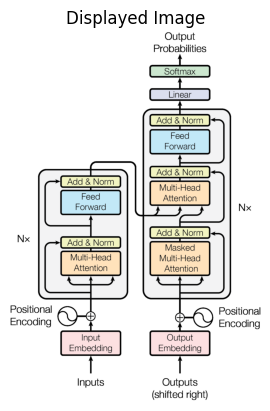

Matching image: 9471368c-6301-4d73-a15e-199902003b16..png, Distance: 1.5110442638397217


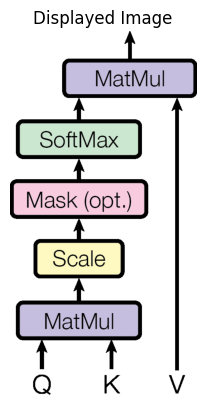

In [ ]:

query = "Define Feed Forward Layer and Add & Norm"
results = clip.retrieve_image(query, top_k=2)
for doc_id, distance in results:
    print(f"Matching image: {doc_id}.png, Distance: {distance}")
    image = Image.open(os.path.join(image_dir,f"{doc_id}.png"))
    # Plot the image using matplotlib
    plt.imshow(image)
    plt.axis('off')  
    plt.title("Displayed Image")
    plt.show()